# Pandas tips

In [10]:
import pandas as pd
import numpy as np
from numpy import random

In [8]:
df = pd.DataFrame({'A': [1,2,3]})
df

,A
0,1
1,2
2,3


In [48]:
data = random.normal(size=(10,3))
df = pd.DataFrame(data,columns=('A','B','C'))
df['D'] = random.laplace(size=10)
df['2A'] = 2*df.A
df

,A,B,C,D,2A
0,1.789567,1.367896,0.486182,0.158322,3.579134
1,-0.500382,-0.869954,0.315988,-0.838246,-1.000765
2,-0.505077,0.485016,-0.088056,0.938321,-1.010153
3,-0.591034,0.662306,0.613959,-0.165808,-1.182069
4,0.320761,-0.167972,-0.707645,0.161045,0.641523
5,-1.406273,1.196132,-2.087683,0.441633,-2.812547
6,-0.624474,-0.602181,-0.927015,-2.388367,-1.248947
7,-0.657208,-0.472566,0.647971,1.524729,-1.314415
8,-0.817316,2.268183,-0.265347,-0.490903,-1.634632
9,-0.279379,-0.408569,-1.181713,-1.013014,-0.558757


# Two modes (binary choice)

We are going to work with a choice between walking and bus. The DM chooses whether to walk or to take the bus.

$$
P_w = \frac{
\exp(V_w)
}{
\exp(V_w)+\exp(V_b)
} = \frac{1}{1+\exp(V_b-V_w)}
 = \frac{1}{1+\exp(-\Delta V)}
$$
where $\Delta V = V_w -V_b$

<AxesSubplot:xlabel='ΔV', ylabel='Pw'>

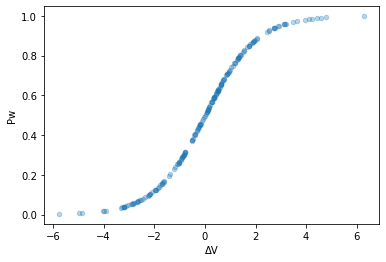

In [58]:
data = random.laplace(scale=1,size =(200,2))
df = pd.DataFrame(data,columns= ('Vw','Vb'))
df['Pw'] = np.exp(df.Vw)/(np.exp(df.Vb)+ np.exp(df.Vw))
df['ΔV'] = df.Vw-df.Vb
df.plot(x='ΔV',y='Pw',kind='scatter',alpha=0.3)

# Deriving the utilities
So, above, the utilities $V_b$ and $V_w$ were randomly generated. Now they'll arise from **attributes** of the two modes.

,Tb,Tw,Mb,Vw,Vb,Pw,ΔV
0,4.754939,2.580177,0.560968,-5.160354,-11.070846,0.997296,5.910492
1,0.076540,4.382313,0.133902,-8.764625,-1.286982,0.000565,-7.477644
2,0.394727,1.535855,0.426177,-3.071709,-2.215631,0.298159,-0.856078
3,3.704621,0.806580,0.226198,-1.613160,-8.635441,0.999109,7.022281
4,0.142292,0.708097,0.598779,-1.416195,-1.883363,0.614713,0.467168
5,2.109808,5.531953,0.214746,-11.063906,-5.434362,0.003577,-5.629544
6,0.668651,0.063841,0.416099,-0.127683,-2.753400,0.932498,2.625718
7,0.089266,3.879173,0.003467,-7.758346,-1.181998,0.001391,-6.576347
8,1.053226,0.580959,0.483116,-1.161919,-3.589568,0.918912,2.427649
9,1.402477,3.494600,0.058706,-6.989201,-3.863659,0.042066,-3.125542


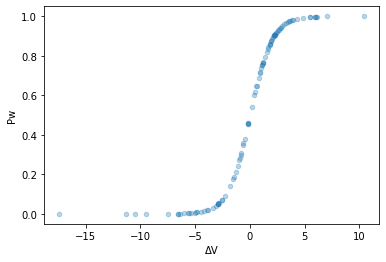

In [101]:
# T is travel time
# M is money cost

βT = -2 #coefficient of travel time in the indirect utility functions
βM = -1 #coefficient of money cost
# ascW = 1 #alternative specific constant
ascB = -1 #alternative specific constant


Vw = lambda T: βT * T #the indirect utility function for walking
Vb = lambda T,M: ascB + βT*T + βM*M # the indirect utility fnction for bus


df2 = pd.DataFrame({
    'Tb': random.gamma(1,scale=1,size=100),
    'Tw': random.gamma(1,scale=1.5,size=100),
    'Mb': random.gamma(1,scale=0.5,size=100)
})

# df2.Tb.plot.hist()
# df2.Tw.plot.hist(alpha=0.5)
# df2.Mb.mean()

# df2.head(10)

df2['Vw'] = Vw(df2.Tw)
df2['Vb'] = Vb(df2.Tb,df2.Mb)
# df2['Pw'] = np.exp(df2.Vw)/(np.exp(df2.Vb)+ np.exp(df2.Vw))


def PW_fun(row):
    Vw = row.Vw
    Vb = row.Vb
    return np.exp(Vw)/(np.exp(Vb)+np.exp(Vw))

df2['Pw'] = df2.apply(PW_fun,result_type='expand',axis=1)

df2['ΔV'] = df2.Vw - df2.Vb
df2.plot(x='ΔV',y='Pw',kind='scatter',alpha=0.3)
df2.head(10)

In [102]:
df2['BlockPop'] = random.uniform(low=150,high=300,size=100).round(0)
df2['BlockWalk'] = (df2.Pw*df2.BlockPop).round()
df2.head(10)
df2.BlockWalk.sum()/df2.BlockPop.sum()

0.5310279701411997

# Possible answer to problem 3 on homework 1

In [110]:
import scipy.optimize as opt
y = 10
α = 0.65
u = lambda x,z: x**α * (z-1)**(1-α)

p = 3

df = pd.DataFrame({'p':[1,2,3,4,5]})
def forEachRow(row):
    p = row.p
    constraints = {'type':'ineq','fun': lambda xs: y - xs[0]*p - xs[1]}
    res = opt.minimize(lambda xs: -u(xs[0],xs[1]),constraints=constraints,bounds=((0,None),(0,None)),x0=(1,1))
    return (res.x[0],res.x[1],-res.fun)


df[['xstar','zstar','v']] = df.apply(forEachRow,result_type='expand',axis=1)

,p,xstar,zstar,v
0,1,5.850220,4.149780,4.710424
1,2,2.925282,4.149436,3.001860
2,3,1.950513,4.148460,2.306382
3,4,2.247870,1.008520,0.319380
4,5,1.798257,1.008716,0.278457
